# 使用Amazon FSx for Lustre 和 Amazon EFS 作数据源加快 Amazon Sagemaker 训练

在 Amazon SageMaker 中训练模型一般使用 Amazon S3 作为存储配合使用。事实上SageMaker做模型训练时已经支持多种数据源，比如 Amazon FSx for Lustre 和 Amazon Elastic File System (EFS) 。本文主要介绍Sagemaker与EFS和FSx配合使用的方法。


![image.png](architect-sagemaker-efs.png)


# 环境准备

首先创建一些使用AWS服务所需的授权和环境。包含三部分：<br /> 
1. 模型训练所需的权限， 这个会自动从创建笔记本的role中自动获取 <br /> 
2. 指定存储训练数据和模型的S3存储桶 <br /> 
3. 指定模型训练的算法：本次实验使用Amazon Sagemaker 中预训练好的图像分类算法docker image<br /> 
4. 指定模型训练输出路径

In [1]:
%%time
!pwd
import boto3
import re
import os 

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
print(role)
sess = sagemaker.Session()
role = get_execution_role()

bucket = sess.default_bucket()
print('Default bucket:{}'.format(bucket))
prefix = 'car-classifier'

training_image = get_image_uri(sess.boto_region_name, 'image-classification')
print(training_image)

# Setup an output S3 location for the model artifact
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

/home/ec2-user/SageMaker/sagemaker-with-file-system-data-source
arn:aws-cn:iam::383709301087:role/sgbootcamp-internal-SageMakerExecutionRole-1HIZ19SFK76J4


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Default bucket:sagemaker-cn-north-1-383709301087
390948362332.dkr.ecr.cn-north-1.amazonaws.com.cn/image-classification:1
training artifacts will be uploaded to: s3://sagemaker-cn-north-1-383709301087/car-classifier/output
CPU times: user 1.03 s, sys: 98.4 ms, total: 1.13 s
Wall time: 4.38 s


## 定义数据源

本次使用的训练数据集是开源的斯坦福大学提供的开源数据集"Cars"。该数据集包含 16,185 张 196 种汽车的图像。使用im2rec脚本制作的训练集train.rec和validation.rec大约175M。
使用文件系统作为数据源，可以节省训练任务中花在下载数据和流式传输数据上的时间。<br /> 
接下来，我们指定文件系统的详细信息作为后续训练任务的输入。
1. 指定文件系统ID和数据所在路径：文件系统id在EFS或Fsx服务页面可以获取，数据所在路径是看测试rec文件在文件系统的相对路径；
2. 选择文件系统类型：`"EFS"` 或者 `"FSxLustre"`；
3. 文件系统访问模式： `'ro'`(只读) 或者 `'rw' `(可读可写)，内置算法只支持以只读的方式挂载；
4. 提供子网和安全组，这两个参数在后续定义训练任务时会用到。训练任务实例最好跟文件系统放在一个子网内，如果是在不同VPC内需要通过VPC Peering打通两个VPC，让训练任务实例能够挂载文件系统。

In [2]:
from sagemaker.inputs import FileSystemInput

# 指定文件系统id,在EFS或Fsx服务页面可以获取
file_system_id = 'fs-faxxxxd67'
#file_system_id = 'fs-03042xxxxa32690'

# 提供数据集所在的路径，注意格式. 
file_system_directory_train_path = '/train'
file_system_directory_val_path = '/validation'

# 指定文件系统的类型, 支持"EFS" 或 "FSxLustre"两种..
file_system_type = 'EFS'
#file_system_type = 'FSxLustre'

# 指定挂载文件系统的访问模式，支持"ro"（只读）或"rw"（读写）两种，注意内置算法只支持 以 ro 的方式挂载
file_system_access_mode = 'ro'

# 以VPC内的方式启动 Amazon SageMaker 训练任务,指定所在子网和安全组，subnet需要为list或者tuple格式
security_groups_ids = ['sg-98d94ffe']
subnets = ['subnet-c666f5a2']

#定义数据输入
file_system_input_train = FileSystemInput(file_system_id=file_system_id,
                                    file_system_type=file_system_type,
                                    directory_path=file_system_directory_train_path,
                                    file_system_access_mode=file_system_access_mode,
                                    content_type='application/x-recordio')
file_system_input_val = FileSystemInput(file_system_id=file_system_id,
                                    file_system_type=file_system_type,
                                    directory_path=file_system_directory_val_path,
                                    content_type='application/x-recordio',
                                    file_system_access_mode=file_system_access_mode)

## 模型训练
本次实验选择内置的图像分类算法，主要是第二部分对文件系统做定义。<br /> 
对比基于S3做数据源的模型训练任务，本次实验因为要使用VPC内的EFS，FSx文件系统，在定义训练任务的时候需要定义`“subnets” `和 `“security_group_ids”`，让训练任务实例以vpc内的方式启动。
1. 选择SageMaker内置image-classification算法 https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html 
2. 创建 SageMaker API 来构建对应的训练任务：指定训练的输入与输出，训练的计算实例配置，这里，我们使用的是 ml.p3.2xlarge GPU 实例。
3. 定义定义超参数以及数据集位置
4. 开始模型训练

Ps: 需要注意的是，sagemaker notebook用于进行本地的数据处理，也可以直接在命令行窗口使用“mount”命令来挂载EFS&FSx文件系统。做完数据处理之后模型训练，模型推理创建新的训练任务实例，可以根据不同的计算任务的需求进行不同的机型选择，通过指定文件系统ID直接使用处理之后的数据。

In [3]:
import time
job_name = 'DEMO-spot-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
train_use_spot_instances=False
checkpoint_s3_uri = ('s3://{}/{}/checkpoints/{}'.format(bucket, prefix, job_name) if train_use_spot_instances 
                      else None)
ic = sagemaker.estimator.Estimator(training_image,
                                     role, 
                                     subnets=subnets,
                                     security_group_ids=security_groups_ids,
                                     train_instance_count=1, 
                                     train_instance_type='ml.p3.8xlarge',
                                     train_use_spot_instances=train_use_spot_instances,
                                     train_max_wait=3600 if train_use_spot_instances else None,
                                     checkpoint_s3_uri=checkpoint_s3_uri,
                                     train_volume_size = 50,
                                     train_max_run = 3600,
                                     input_mode= 'File',
                                     output_path=s3_output_location,
                                     sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_use_spot_instances has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_wait has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [4]:
#定义超参数
ic.set_hyperparameters(num_layers=18,
                         image_shape = "3,224,224",
                         use_pretrained_model=1,
                         num_classes=3,
                         num_training_samples=96,
                         mini_batch_size=30,
                         epochs=100,
                         learning_rate=0.01,
                         top_k=2,
                         precision_dtype='float32')

In [5]:
#定义数据源位置
data_channels = {'train': file_system_input_train, 'validation': file_system_input_val}

In [6]:
ic.fit(inputs=data_channels, logs=True)

2021-01-24 09:31:56 Starting - Starting the training job...
2021-01-24 09:32:13 Starting - Launching requested ML instances......
2021-01-24 09:33:24 Starting - Preparing the instances for training............
2021-01-24 09:35:21 Downloading - Downloading input data...
2021-01-24 09:35:41 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
[01/24/2021 09:36:38 INFO 139779327985472] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[01/24/2021 09:36:38 INFO 139779327985472] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: 

等到返回Training job completed之后，表示训练任务完成。或者在控制台训练任务状态为completed时，代表训练完成。
- 训练完成之后可以在Sagemaker Console中可以查询训练任务进程，训练时间由训练实例类型和训练epoch决定
- 训练过程可以在cloudwatch查看训练loss的参数
- 在SageMaker控制台台上查看”历史记录“，如下图所示

![image.png](history-task.png)

# 模型部署
<kbd>用时约6分钟</kbd> <br />
训练结束后，我们在之前配置的S3存储桶就获得了最新的模型文件。我们接下来，将其进行线上部署，这样就可以通过接受来自客户端的Restful API请求进行预测。

In [30]:
ic_classifier = ic.deploy(initial_instance_count = 1, instance_type = 'ml.m5.xlarge')

---------------!

# 推理及应用
<kbd>用时约2分钟</kbd> <br />
现在我们使用一个随意挑选的车的图片进行型号的分类。
我们直接调用创建的endpoint进行推理，可以看到结果与概率，可以看到，准确的判断出了相对应的分类。这里的概率并不是非常高，但鉴于我们作为范例只训练了不多的epoch，已经是个很不错的结果了。如果想要得到更高的准确率，请使用完整数据集进行更多轮次的训练。

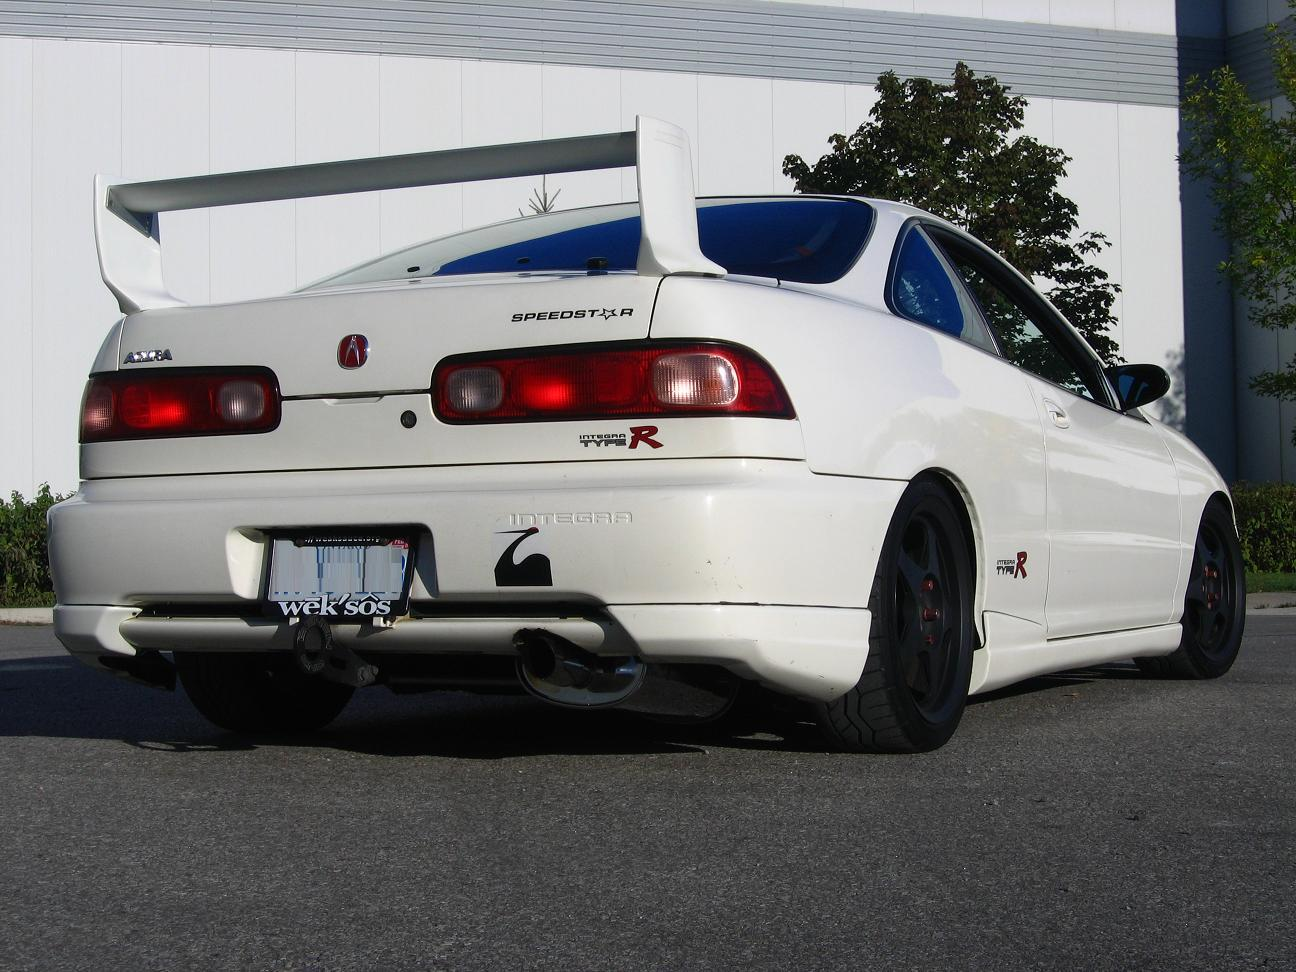

In [29]:
import random
from IPython.display import Image

car = 'Acura Integra Type R 2001/'
testls = os.listdir('car_data_sample/test/'+car)
file_name = 'car_data_sample/test/'+car+testls[random.randint(0,len(testls)-1)]

# test image
Image(file_name)  

In [31]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
ic_classifier.content_type = 'application/x-image'
result = json.loads(ic_classifier.predict(payload))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - Acura TL Sedan 2012, probability - 0.643511176109314


以上就是一个完整的使用Amazon Sagemaker构建图像分类模型，训练，部署的过程。您可以将它进行修改，完成不同场景下自己的图像分类任务。

# 最后一步,清除资源
<kbd>用时约1分钟</kbd> <br />
完成测试后，清除访问端点资源

In [ ]:
ic_classifier.delete_endpoint()